# UK Road Safety: Traffic Accidents and Vehicles - Model Deployment
## Detailed dataset of road accidents and involved vehicles in the UK (2005-2016)
Source:
<u>https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles#Accident_Information.csv </u>
    



# Standard imports
+useful figure save function

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import random as rnd
import numpy as np
import pandas as pd
import sys
import io
import datetime
from matplotlib import pyplot as plt
from collections import Counter
import logging
import time
import math


#prevents intrusive spark debug notificaitions
logging.getLogger("py4j").setLevel(logging.ERROR)



mypath_ = !pwd

def save_fig(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #generic function to save images to file
    filename =  mypath_[0]+'/img/' + fig_txt + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    fig_id.savefig(filename, format=fig_extension, dpi=resolution, bbox_inches='tight')
    file_data=open(filename, 'rb')
    project.save_data(data=file_data.read(),file_name=fig_txt+'.png',overwrite=True)
    file_data.close() 
    
    
def save_fig_memory(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #saving images to memory then BlueMix then CloudantdB without the need to save to file
    buf = io.BytesIO()
    filename =  mypath_[0]+'/img/' + fig_txt + "." + fig_extension
    fig_id.savefig(buf, format=fig_extension, dpi=resolution, bbox_inches='tight')
    buf.seek(0)
    project.save_data(data=buf.read(),file_name=fig_txt+'.png',overwrite=True)
    return buf


# Load data from Parquet files
Load the previously transformed dataset<br>

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

rdd_accidents = spark.read.load("accidents_tr.parquet")

#Uncomment to select subset of the data
######################## UNCOMMENT FOR TESTING ##########################
#rdd_accidents = rdd_accidents.sample(withReplacement=False, fraction=0.1)
#########################################################################


rdd_accidents.head()
rdd_accidents.createOrReplaceTempView("accidents")
#rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))


number of records: 1775183


## Load Packages

In [4]:
from pyspark.sql import functions as F 
from pyspark.sql.functions import *
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, IndexToString, VectorIndexer
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import Evaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
import geopandas as gpd
import os, io
from cloudant.client import Cloudant
from cloudant.error import CloudantException
from cloudant.result import Result, ResultByKey
import base64
from cloudant.document import Document
from simplejson.decoder import JSONDecoder as json_decoder



rnd_seed=42 #for reproductibility

# Use case: predict accident severity at each output area (LSOA) given datetime and driving conditions
<b>We will be looking at one Police Force to start with and only retain a few features based on our use case:</b><br>
<br>
<em>Given date, time, weather, light and road conditions, predict accident severity within the operating geographic area of a police force</em> <br>
<br>
<b>The deliverable is a tool that should faciliate ressource allocation to mitigate the probability of serious accidents given current driving conditions</b>

In [5]:
#some global variables

plt.style.use('seaborn-whitegrid')
cmap=plt.get_cmap('Pastel2')


retained_features=[
    'Accident_Severity',
    'LSOA_of_Accident_Location',
    'Police_Force',
    'Latitude',
    'Longitude',
    'Weather_Conditions',
    'Light_Conditions',
    'Road_Surface_Conditions',
    'Day_of_Week',
    'Hour',
    'Week',
    'Peak_or_OffPeak',
    'Centroid_Latitude',
    'Centroid_Longitude']

features={
    'response':'Accident_Severity',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}

#Generating some global variables

#Get list of categorical variable values
#fit the encoder over the whole data_set
columns = ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'Peak_or_OffPeak']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_accidents) for column in columns]
cat_features = ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'Peak_or_OffPeak']
cat_mappings ={}
for i, cat_feat in enumerate(cat_features):
    cat_mappings[cat_feat] = indexers[i].labels
    

#Get list of avalaible models
models_list=os.listdir(r"models")
police_force_list = [m[0:-4].replace('_', ' ') for m in models_list]


#Get Dataframe of Police Force and LSOAs
sql_query = '''
    SELECT 
    DISTINCT LSOA_of_Accident_Location, 
    Police_Force, 
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, 
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude 
    FROM accidents GROUP BY Police_Force, LSOA_of_Accident_Location'''

police_force_LSOAs = spark.sql(sql_query).toPandas()




def to_null(c):
        #function to discard NUL NA and empty records
        from pyspark.sql.functions import col, isnan, when, trim
        return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))
    

    
def load_data(group=data_group, feats=retained_features, verbose=False):
#load data from one group into RDD selecting only retained features and create view
    sql_query= '''SELECT {} FROM {} WHERE {}={}'''
    try:
        if group['name']=='All':
            rdd_data = spark.sql("SELECT {} from accidents".format(', '.join(feats)))
        else:
            rdd_data = spark.sql(sql_query.format(', '.join(feats), "accidents", group['name'], "'"+group['item']+"'"))
        #remove any null or empty entries
        rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
        #print(rdd_data.head())
        rdd_data.createOrReplaceTempView("data")
        nb_slight  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Slight'").collect()[0][0]
        nb_severe  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Serious'").collect()[0][0]
        print("nb Slight:{:d}, nb Serious:{:d}, %Slight: {:.1f}%".format(nb_slight, nb_severe, 100*nb_slight/(nb_slight+nb_severe)))
        return rdd_data
    except:
        print("{} not found in {}".format(group['item'], group['name']))
        return None      
                 
             
def summarize_data_by_lsoa(rdd_data, feats = retained_features[1:], verbose=False):
    #summarize data by output area
    rdd_data.createOrReplaceTempView("data")
    severe_col = 'Accident_Severity'
    acc_type = "Slight"
    lsoa = 'LSOA_of_Accident_Location'
    sql_query = '''
        SELECT {0},
        COUNT(CASE WHEN {1}  = '{2}' THEN {3} END) AS Slight, 
        COUNT(CASE WHEN {1} != '{2}' THEN {3} END) AS Serious 
        FROM {4} GROUP BY {5}'''
    feats = feats + ([lsoa] if lsoa not in feats else [])
    new_rdd = spark.sql(sql_query.format(', '.join(feats), severe_col, acc_type, severe_col, "data", ', '.join(feats)))
    new_rdd = new_rdd.withColumn('Severity_Pct', (new_rdd['Serious']/(new_rdd['Slight']+new_rdd['Serious'])).cast('double'))
    try:
        new_rdd.select([to_null(c).alias(c) for c in new_rdd.columns]).na.drop()
    except:
        if verbose: print("Standard NA.drop only")
        new_rdd.na.drop()
    return new_rdd


def load_rdd_data_and_string_encode(group=data_group, features=features):
    #Load data and string-encode all categorical variables
    rdd_data = load_data(group=group)
    rdd_data, columns_index = string_encode(rdd_data, features['cat_pred'])
    new_features={}
    new_features['cat_pred'] = columns_index[:-1]
    new_features['response'] = columns_index[-1]
    return rdd_data, new_features

def load_and_split_data(group=data_group, features=features):
    #generic load and split
    rdd_data, new_features = load_rdd_data(group, features)
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features


def load_and_split_data_with_centroids(group=data_group, features=features, verbose=False):
    #load add centroid data and split (no longer needed in next iteration)
    rdd_data, new_features = load_rdd_data(group, features, verbose=verbose)
    lsoa_data = spark.sql("SELECT LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,\
          PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, PERCENTILE(Longitude, 0.5) AS Centroid_Longitude \
          FROM accidents GROUP BY LSOA_of_Accident_Location")
    rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
    #remove null values
    rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features

    
    
def string_encode(rdd_data, columns):
    #string encode categorical variables using a list of stacked pipelines
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_accidents) for column in columns]
    index_pipeline = Pipeline(stages=indexers)
    columns_index = [x+'_index' for x in columns]
    return index_pipeline.fit(rdd_data).transform(rdd_data), columns_index


def one_hot_encode(rdd_data, columns):
    #one_hot_encode categorical variables
    for column in columns:
        try:
            rdd_data = OneHotEncoder(inputCol=column, outputCol=column+"_vec").transform(rdd_data)
        except:
            print("One_hot encoding already performed for ", column)
    columns_vec = [x+'_vec' for x in columns]
    return rdd_data, columns_vec



def load_one_hot_and_split_data_with_centroids(group=data_group, features=features, verbose=False):
    #Because of the vectorisation of features required by spark ML,
    #we have to either normalise all features or none 
    #This means that we now have to explicitly one-hot encode the categorical features
    #The encoding has to be done before the train/test split to ensure that it is consistent across both sets
    #The fianl step is aggregating the data by lsoa and compute our response feature
    if verbose: print("loading and formatting data...")
    start_time = time.time()
    rdd_data = load_data(group=group)
    rdd_data.cache()
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    #remove null values
    rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    #one_one encode categorical data
    rdd_data, new_features['cat_pred'] = string_encode(rdd_data, new_features['cat_pred'])
    rdd_data, new_features['cat_pred_vec'] = one_hot_encode(rdd_data, new_features['cat_pred'])
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    rdd_data.unpersist()
    rdd_train.cache()
    rdd_test.cache()
    rdd_train = summarize_data_by_lsoa(rdd_train, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    rdd_test = summarize_data_by_lsoa(rdd_test, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    if verbose: print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_train, rdd_test, new_features


def load_trained_model(police_force, verbose=False):
    data_group['item'] =  police_force
    f_name = police_force.replace(' ','_') + '.gbt'
    try:
        if verbose: print("=====>Loading {} police force data".format(data_group['item'].replace(' ','_')))
        model = PipelineModel.load('models/' + f_name)
        rdd_train, rdd_test, ml_feats= load_one_hot_and_split_data_with_centroids(data_group, features, verbose=verbose)
        return model, rdd_train, rdd_test
    except:
        return None

    
def get_model(police_force, verbose=False):
    model, rdd_train, rdd_test = load_trained_model(police_force, verbose=verbose)
    pred_test, rmse_test, r2_test = evaluate_reg_model(model, rdd_test, "test", response='Severity_Pct', verbose=verbose)
    return model, rmse_test, r2_test


    
def evaluate_reg_model(model, rdd_data, set_name, response=features["response"], verbose=False):
    #Calculate root mean squared error as a performance measures
    if verbose: print("evaluation start...")
    start_time = time.time()    
    pred_test = model.transform(rdd_data)
    #evaluator = RegressionEvaluator(labelCol=response, predictionCol="prediction", metricName="rmse")
    #rmse = evaluator.evaluate(predY)
    pred_val = pred_test.rdd.map(lambda row: (float(row['prediction']), float(row['Severity_Pct'])))
    metrics = RegressionMetrics(pred_val)
    #metrics = RegressionMetrics
    if verbose: print("Root Mean Squared Error (RMSE) on {} data = {:.2f}".format(set_name, metrics.rootMeanSquaredError)) 
    if verbose: print("R2 (explained variance ratio) on {} data = {:.2f}".format(set_name, metrics.r2)) 
    if verbose: print("evaluation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return pred_test, metrics.rootMeanSquaredError, metrics.r2



def create_query_rdd(query, police_force):
    from pyspark.sql import Row
    schema = StructType([
        StructField('Weather_Conditions', StringType(), True),
        StructField('Light_Conditions', StringType(), True),
        StructField('Road_Surface_Conditions', StringType(), True),
        StructField('Day_of_Week', StringType(), True),
        StructField('Peak_or_OffPeak', StringType(), True),
        StructField('Centroid_Latitude', DoubleType(), True),
        StructField('Centroid_Longitude', DoubleType(), True),
        StructField('LSOA_of_Accident_Location', StringType(), True),
        StructField('Severity_Pct', DoubleType(), True)])   
    row_list = []
    df = police_force_LSOAs[police_force_LSOAs['Police_Force']==police_force]
    for lsoa in list(df['LSOA_of_Accident_Location'].values):
        query['LSOA_of_Accident_Location'] = lsoa
        query['Centroid_Latitude'] = float(df[df['LSOA_of_Accident_Location']==lsoa].Centroid_Latitude.values[0])
        query['Centroid_Longitude'] = float(df[df['LSOA_of_Accident_Location']==lsoa].Centroid_Longitude.values[0])
        query['Severity_Pct'] = float(0)
        row_list.append(Row(**query))
    rdd_query = sqlContext.createDataFrame(row_list, schema)
    return rdd_query


def create_and_predict_query_rdd(model, police_force, query_dict, verbose=False):
    if verbose: print("query creation start...")
    start_time = time.time()    
    rdd_query = create_query_rdd(query_dict, police_force)
    rdd_query = predict(model, rdd_query)
    if verbose: print("query creation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_query


def update_query_rdd(model, rdd_query, new_query_data, verbose=False):
    if verbose: print("query update start...")
    start_time = time.time()    
    rdd_query.cache()
    for (update_col, new_value) in new_query_data.items():
        rdd_query = rdd_query.withColumn(update_col, lit(new_value))
    rdd_query = predict(model, rdd_query)
    rdd_query.unpersist()
    if verbose: print("query update completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_query



def predict(model, rdd_query):
    rdd_query.cache()
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']    
    rdd_query_pred, new_features['cat_pred'] = string_encode(rdd_query, new_features['cat_pred'])
    rdd_query_pred, new_features['cat_pred_vec'] = one_hot_encode(rdd_query_pred, new_features['cat_pred'])
    rdd_query_pred =  model.transform(rdd_query_pred)    
    rdd_query.unpersist()
    return rdd_query_pred
    

def generate_map(police_force, verbose=False):
    if verbose: print("generating map...")
    start_time = time.time()    
    df_lsoa = police_force_LSOAs[police_force_LSOAs['Police_Force']==police_force]
    if verbose: print("loading global map")
    fname = "Lower_Layer_Super_Output_Areas_December_2001_Generalised_Clipped_Boundaries_in_England_and_Wales.shp"
    map_df = gpd.read_file(fname)
    #pf_loc = police_force
    if verbose: print("filtering map by lsoa")
    map_df = map_df[map_df['lsoa01cd'].isin(df_lsoa['LSOA_of_Accident_Location'].values)]
    map_df = map_df.rename(columns={'lsoa01cd': 'LSOA_of_Accident_Location'})
    if verbose: print("map generation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return map_df
    
    
def update_map(map_df, rdd_query, verbose=False):
    if verbose: print("updating map...")
    start_time = time.time()    
    query_df = rdd_query.toPandas()[['LSOA_of_Accident_Location', 'prediction']]
    query_df = query_df[query_df['LSOA_of_Accident_Location'].isin(map_df['LSOA_of_Accident_Location'].values)]
    if 'prediction' in map_df: map_df.drop(['prediction'], axis=1)
    map_df = map_df.merge(query_df)
    if verbose: print("map update completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return map_df

    
    
def plot_map(map_df, police_force, test_query, rmse_test, r2_test, verbose=False):
    if verbose: print("plotting map")
    start_time = time.time()    
    # set the range for the choropleth
    color_map = 'RdYlBu_r'
    #vmin, vmax = map_df.prediction.min(), map_df.prediction.max()
    vmin, vmax = 0, 1
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10), gridspec_kw={'width_ratios':[1,2]})
    mp = map_df.plot(column='prediction', cmap=color_map, linewidth=0.8, ax=ax2, edgecolor='0.8', vmin=0, vmax=1)
    #sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm = plt.cm.ScalarMappable(cmap=color_map)
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm, fraction=0.046, pad=0.04)
    plt.axis('equal')
    ax1.axis('off')
    ax2.axis('off')
    textstr_c = '\n\n'+'\n\n\n'.join([c+': 'for (c, v) in [(k,v) for (k,v) in test_query.items() if k in cat_features]])+'\n\n'
    textstr_v = '\n\n'+'\n\n\n'.join([v for (c, v) in [(k,v) for (k,v) in test_query.items() if k in cat_features]])+'\n\n'
    props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # place a text box in upper left in axes coords
    ax1.text(0.5, 0.95, "Police force: "+police_force, transform=ax1.transAxes, fontsize=18,
            va='top', ha='center',fontweight='bold', bbox=props)
    ax1.text(0.0, 0.5, textstr_c, transform=ax1.transAxes, fontsize=14,
            va='center', ha='left', fontweight='bold')
    ax1.text(0.83, 0.5, textstr_v, transform=ax1.transAxes, fontsize=14,
            va='center', ha='left', style='italic')
    ax1.text(0.5, 0.10, "Accident severity ratio predicted by GBT regressor", transform=ax1.transAxes, fontsize=12,
            va='bottom', ha='center')
    ax1.text(0.5, 0.05, "Test set metrics: rmse={:.2f}, R2={:.2f}".format(rmse_test, r2_test), transform=ax1.transAxes, fontsize=12,
            va='bottom', ha='center')
    plt.show()
    if verbose: print("map plot completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return fig


def save_map_in_memory(map_df, police_force, test_query, verbose=False):
    if verbose: print("saving map")
    start_time = time.time()    
    # set the range for the choropleth
    color_map = 'RdYlBu_r'
    #vmin, vmax = map_df.prediction.min(), map_df.prediction.max()
    vmin, vmax = 0, 1
    fig, ax = plt.subplots(figsize=(8,10))
    mp = map_df.plot(column='prediction', cmap=color_map, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax=1)
    #sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm = plt.cm.ScalarMappable(cmap=color_map)
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm, fraction=0.046, pad=0.04)
    ax.set_aspect('equal')
    ax.axis('off')   
    plt.tight_layout()
    #save_fig(fig, police_force, tight_layout=True, fig_extension="png", resolution=300)
    plt.close(fig)
    if verbose: print("map saved completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return fig



#Plot inset map
def plot_inset(pfModel):
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

    fname = "Lower_Layer_Super_Output_Areas_December_2001_Generalised_Clipped_Boundaries_in_England_and_Wales.shp"
    map_df = gpd.read_file(fname)
    #pf_loc = police_force
    map_df = map_df.rename(columns={'lsoa01cd': 'LSOA_of_Accident_Location'})
    map_df = map_df.merge(police_force_LSOAs)
    pf_map = map_df.dissolve(by='Police_Force', aggfunc='sum')
    fig, ax = plt.subplots(figsize=(5,7))
    pf_map.plot(column = 'st_areasha', cmap='bone', ax=ax)
    ax.set_aspect('equal')
    #ax.grid('off')   
    ax.axis('off')   
    police_force = pfModel.police_force
    f_map_df = map_df[map_df['Police_Force']==police_force]

    axins = zoomed_inset_axes(ax, 3, loc=2) # zoom-factor: 2.5, location: upper-left
    pfModel.map.plot(column='prediction', cmap='RdYlBu_r', linewidth=0.8, edgecolor='0.8', ax=axins)
    x1, y1, x2, y2 = list(pf_map.bounds.loc[police_force]) # specify the limits
    axins.set_xlim(x1, x2) # apply the x-limits
    axins.set_ylim(y1, y2) 
    mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec='r')
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    axins.grid('off')
    save_fig(fig, "inset_map"+"_"+police_force)
    return



class MapModel:
    def __init__(self, police_force, verbose=False):
        self.police_force = police_force
        self.verbose = verbose
        self.model, self.rmse, self.r2  = get_model(police_force)
        self.map = generate_map(police_force, verbose=self.verbose)
        self.query = {}
        self.fig = None
        
    def update(self, query_dict):
        rdd_query = create_and_predict_query_rdd(self.model, self.police_force, query_dict, verbose=self.verbose)
        self.query = query_dict
        self.map = generate_map(self.police_force, verbose=self.verbose) #not necessary but speeds up the update
        self.map = update_map(self.map, rdd_query, verbose=self.verbose)
    
    def plot(self):
        self.fig = plot_map(self.map, self.police_force, self.query, self.rmse, self.r2, verbose=self.verbose)
        
    def save_fig(self):
        self.fig = save_map_in_memory(self.map, self.police_force, self.query, verbose=True)
        
    def save_fig_to_cdB(self, query_db):
        fig = save_map_in_memory(self.map, self.police_force, self.query, verbose=True)
        save_fig_to_cdB(query_db, fig)
        
        
        
        
#Cloudant database management#connect to Cloudant 
serviceUsername = credentials_cloudant['username']
servicePassword = credentials_cloudant['password']
serviceURL = credentials_cloudant['custom_url']
client = Cloudant(serviceUsername, servicePassword, url=serviceURL)
client.connect()


def create_database(db_name):
    database = client.create_database(db_name, throw_on_exists=False)
    if database.exists():
        print("{} database successfully created".format(db_name))
        return database
    else:
        return None
    
def delete_database(db_name):
    try :
        client.delete_database(db_name)
    except CloudantException:
        print("There was a problem deleting {}.\n".format(db_name))
    else:
        print("{} successfully deleted.\n".format(db_name))
    return
        

def create_temp_database(db_name):
    try :
        client.delete_database(db_name)
    except CloudantException:
        pass
    return create_database(db_name)


def save_map_query_to_cdB(police_force, query_dict, rmse, R2):
    query_db = create_temp_database("map_query")
    query_dict['Police_Force'] = police_force
    query_dict['rmse'] = rmse
    query_dict['R2'] = R2
    doc = query_db.create_document(query_dict)
    return query_db, doc


def load_query_from_cdB(query_db):
    json_doc = Result(query_db.all_docs, include_docs=True)[0][0]['doc']
    json_doc.pop('_rev')
    query_id = json_doc['_id']
    return query_id, json_doc
    
    
def save_attachement(query_db, binary_file):
    dataContentb= base64.b64encode(binary_file)
    dataContent = dataContentb.decode()
    query_id, query_dict = load_query_from_cdB(query_db)
    doc = Document(query_db, query_id, decoder=json_decoder)
    doc.put_attachment('map_img.png', 'image/png', dataContent)
    doc.save()
    return

def get_attachement(query_db):
    query_id, query_dict = load_query_from_cdB(query_db)
    doc = Document(query_db, query_id, decoder=json_decoder)
    return doc.get_attachment('map_img.png')



def save_fig_to_cdB(query_db, fig):
    query_id, query_dict = load_query_from_cdB(query_db)
    doc = Document(query_db, query_id, decoder=json_decoder)
    fig_buffer = io.BytesIO()
    fig.savefig(fig_buffer, format='png')
    fig_buffer.seek(0)  # rewind to beginning of file
    #figdata_png = base64.b64encode(figfile.read())
    figdata_encoded = base64.b64encode(fig_buffer.getvalue())  
    #figdata_encoded = figdata_encoded.decode()
    doc.put_attachment('map_img.png', 'image/png', figdata_encoded)
    doc.save()
    return

#Save Police force list to Cloudant dB
police_force_dict = {"pf_list": police_force_list}
pf_db = create_temp_database("police_force")
doc = pf_db.create_document(police_force_dict)
#Save categorical mappings to Cloudant dB
cat_db = create_temp_database("cat_mappings")
for cat in cat_mappings:
    doc = cat_db.create_document({"name":cat, "values":cat_mappings[cat]})



police_force database successfully created
cat_mappings database successfully created


# Initial Run

nb Slight:16149, nb Serious:2719, %Slight: 85.6%
generating map...
loading global map
filtering map by lsoa
map generation completed  - Processing time: 5 secs
query creation start...
query creation completed  - Processing time: 7 secs
generating map...
loading global map
filtering map by lsoa
map generation completed  - Processing time: 4 secs
updating map...
map update completed  - Processing time: 3 secs
plotting map


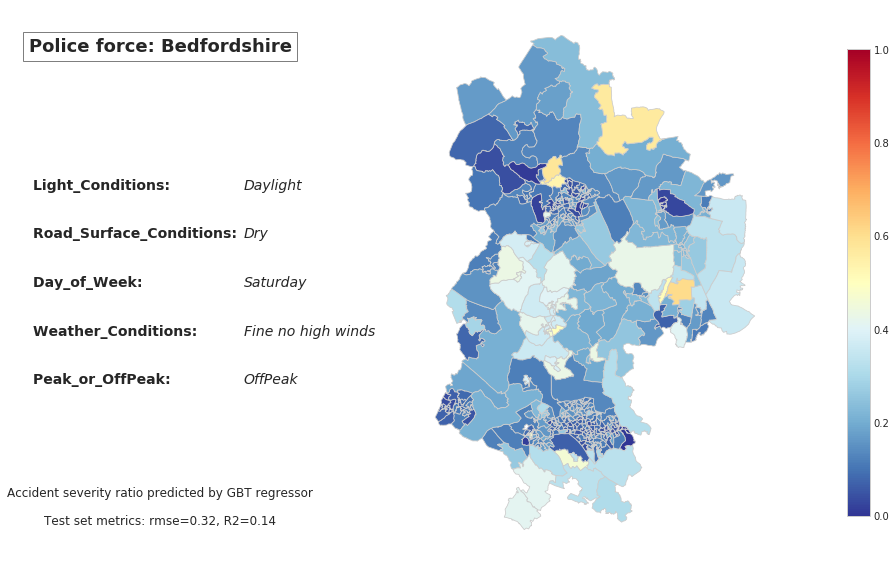

map plot completed  - Processing time: 1 secs
map_query database successfully created
saving map
map saved completed  - Processing time: 0 secs


In [9]:
#INITIAL RUN
test_query = {
    'Day_of_Week': 'Saturday',
    'Light_Conditions': 'Daylight',
    'Road_Surface_Conditions': 'Dry', 
    'Weather_Conditions': 'Fine no high winds',
    'Peak_or_OffPeak': 'OffPeak', 
    'LSOA_of_Accident_Location': '', 
    'Centroid_Latitude': 0, 
    'Centroid_Longitude': 0}

police_force = 'Bedfordshire'
pfModel = MapModel(police_force, verbose=True)
pfModel.update(test_query)
pfModel.plot()


query_db, doc = save_map_query_to_cdB(pfModel.police_force, pfModel.query, pfModel.rmse, pfModel.r2)
query_id, json_doc = load_query_from_cdB(query_db)
pfModel.save_fig_to_cdB(query_db)

# Main Loop

In [25]:
#MAIN LOOP
#read the cloudant database every 5 seconds to determine  whether a new query has been sent
#upadate the query'a attachment with a new map
from IPython.display import clear_output
old_id  = query_id
while True:
    time.sleep(5)
    try:
        query_id, json_doc = load_query_from_cdB(query_db)
    except:
        pass
    if query_id != old_id:
        clear_output(wait=True)
        print("--->new query:")
        print(json_doc)
        police_force = json_doc['Police_Force']
        if police_force != pfModel.police_force:
            print("--->loading new police force data")
            pfModel = MapModel(police_force, verbose=False)
        for k in cat_features:
            test_query[k] = json_doc[k]
        pfModel.update(test_query)
        query_db, doc = save_map_query_to_cdB(pfModel.police_force, pfModel.query, pfModel.rmse, pfModel.r2)
        query_id, query_dict = load_query_from_cdB(query_db)
        try:
            pfModel.save_fig_to_cdB(query_db)
            old_id  = query_id
        except:
            print("saving map failed....retrying") 

--->new query:
{'Centroid_Longitude': 0, 'R2': 0, 'Day_of_Week': 'Peak', 'Weather_Conditions': 'Dry', 'Peak_or_OffPeak': 'Daylight', 'Centroid_Latitude': 0, '_id': '3882bce3d832682a13486c4b8965dc0f', 'Road_Surface_Conditions': 'Fine no high winds', 'rmse': 0, 'Light_Conditions': 'Saturday', 'Police_Force': 'Cumbria', 'LSOA_of_Accident_Location': ''}


Py4JJavaError: An error occurred while calling o5480.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 243.0 failed 10 times, most recent failure: Lost task 0.9 in stage 243.0 (TID 2001, yp-spark-dal09-env5-0036, executor 796b549d-f7bb-4792-9319-7bc0e196787f): org.apache.spark.SparkException: Failed to execute user defined function(: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:377)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:231)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:225)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$26.apply(RDD.scala:847)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$26.apply(RDD.scala:847)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:326)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:290)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:326)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1160)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.lang.Thread.run(Thread.java:811)
Caused by: org.apache.spark.SparkException: Unseen label: Dry.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$4.apply(StringIndexer.scala:170)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$4.apply(StringIndexer.scala:166)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1461)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1449)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1448)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1448)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:803)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:803)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:803)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1676)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1631)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1620)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:629)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1941)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1954)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1967)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1981)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:956)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:381)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:955)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:275)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2772)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2769)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2792)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2769)
	at sun.reflect.GeneratedMethodAccessor122.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:508)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:811)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:377)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:231)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:225)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$26.apply(RDD.scala:847)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$26.apply(RDD.scala:847)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:326)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:290)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:326)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1160)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen label: Dry.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$4.apply(StringIndexer.scala:170)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$4.apply(StringIndexer.scala:166)
	... 16 more
